# Import Libraries

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

# 1.0 Data Understanding 
# 1.1 Load Dataset 

In [201]:
# Load dataset
df = pd.read_csv('video_games_sales.csv')


# Display first five rows
df.head()


,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [202]:
## Rename the month column to date, set date as index

df.rename(columns={"Month": "Date", "Monthly Sales": "Monthly_Sales"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Month_Name"] = df["Date"].dt.month_name()
df.set_index('Date', inplace=True)

#confirm the operation above
df.head(1)

,Category,Monthly_Sales,Year,DayOfWeek,Platform,Holiday,Promotion,Month_Name
Date,,,,,,,,
2002-01-01,Sports,108592,2002,1,Xbox,1,0,January


# 1.2 Dataset Summary

In [203]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()

The Dataset shape is: (264, 8)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2002-01-01 to 2023-12-01
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Monthly_Sales  264 non-null    int64 
 2   Year           264 non-null    int64 
 3   DayOfWeek      264 non-null    int64 
 4   Platform       264 non-null    object
 5   Holiday        264 non-null    int64 
 6   Promotion      264 non-null    int64 
 7   Month_Name     264 non-null    object
dtypes: int64(5), object(3)
memory usage: 18.6+ KB


In [204]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)

Missing Value Description:
               Missing Values  Percentage
Category                    0         0.0
Monthly_Sales               0         0.0
Year                        0         0.0
DayOfWeek                   0         0.0
Platform                    0         0.0
Holiday                     0         0.0
Promotion                   0         0.0
Month_Name                  0         0.0


In [205]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")

The dataset contains 0 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Category           5
Monthly_Sales    264
Year              22
DayOfWeek          7
Platform           4
Holiday            2
Promotion          2
Month_Name        12
dtype: int64


In [206]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Category: {df['Category'].unique()}")
print("---------------------------------------")
print(f"2. Platform: {df['Platform'].unique()}")
print("---------------------------------------")
print(f"3. Holiday: {df['Holiday'].unique()}")
print("---------------------------------------")
print(f"4. Promotion: {df['Promotion'].unique()}")
print("---------------------------------------")
print(f"5. Year: {df['Year'].unique()}")

Unique Values in Categorical Features:
---------------------------------------
1. Category: ['Sports' 'RPG' 'Simulation' 'FPS' 'Adventure']
---------------------------------------
2. Platform: ['Xbox' 'Nintendo' 'PC' 'PlayStation']
---------------------------------------
3. Holiday: [1 0]
---------------------------------------
4. Promotion: [0 1]
---------------------------------------
5. Year: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


# 1.3 Statistical Analysis

In [207]:
# Summary statistics
df.describe(include='all').round(2)

,Category,Monthly_Sales,Year,DayOfWeek,Platform,Holiday,Promotion,Month_Name
count,264,264.00,264.00,264.00,264,264.00,264.0,264
unique,5,NaN,NaN,NaN,4,NaN,NaN,12
top,Sports,NaN,NaN,NaN,Xbox,NaN,NaN,January
freq,59,NaN,NaN,NaN,76,NaN,NaN,22
mean,NaN,112349.00,2012.50,3.01,NaN,0.17,0.2,NaN
std,NaN,34144.61,6.36,2.00,NaN,0.37,0.4,NaN
min,NaN,10469.00,2002.00,0.00,NaN,0.00,0.0,NaN
25%,NaN,88873.75,2007.00,1.00,NaN,0.00,0.0,NaN
50%,NaN,112947.50,2012.50,3.00,NaN,0.00,0.0,NaN
75%,NaN,135193.50,2018.00,5.00,NaN,0.00,0.0,NaN


## 2.0 Exploratory Data Analysis (EDA)

# 2.1 Univariate analysis

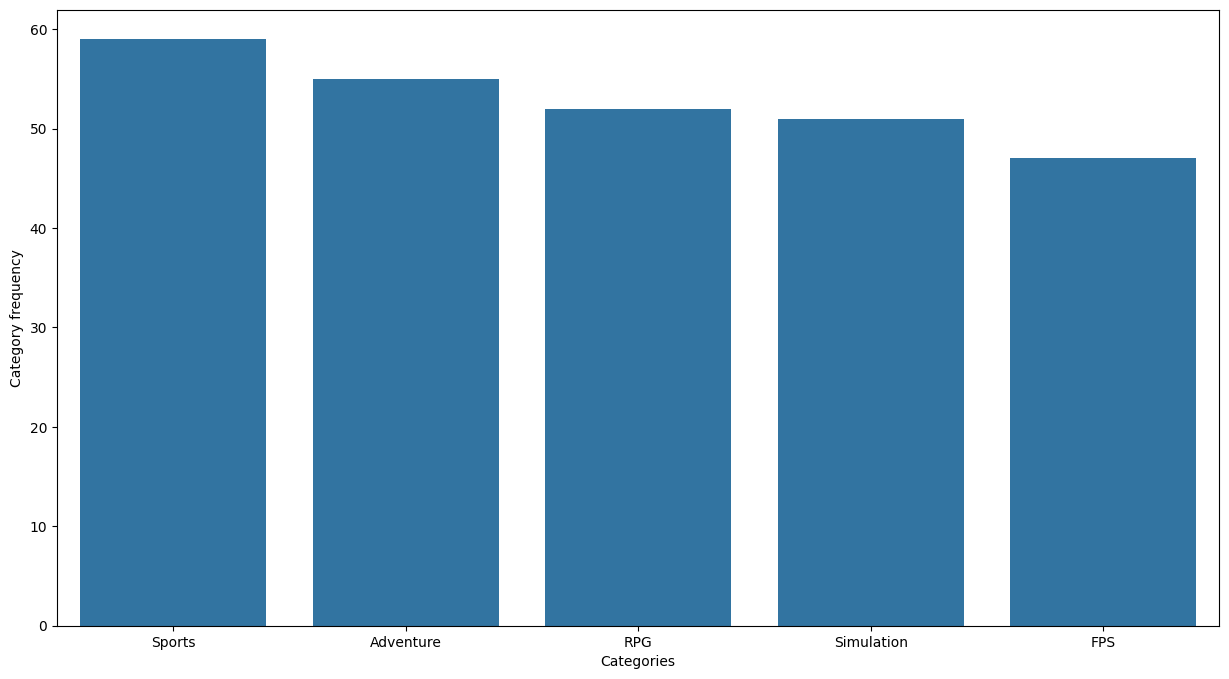

In [208]:
## category count plot

category_order = df["Category"].value_counts().index.tolist()


plt.figure(figsize = (15, 8))


sns.countplot(data = df, x = "Category", order= category_order)

plt.xlabel("Categories")
plt.ylabel("Category frequency")

plt.show(); plt.close()

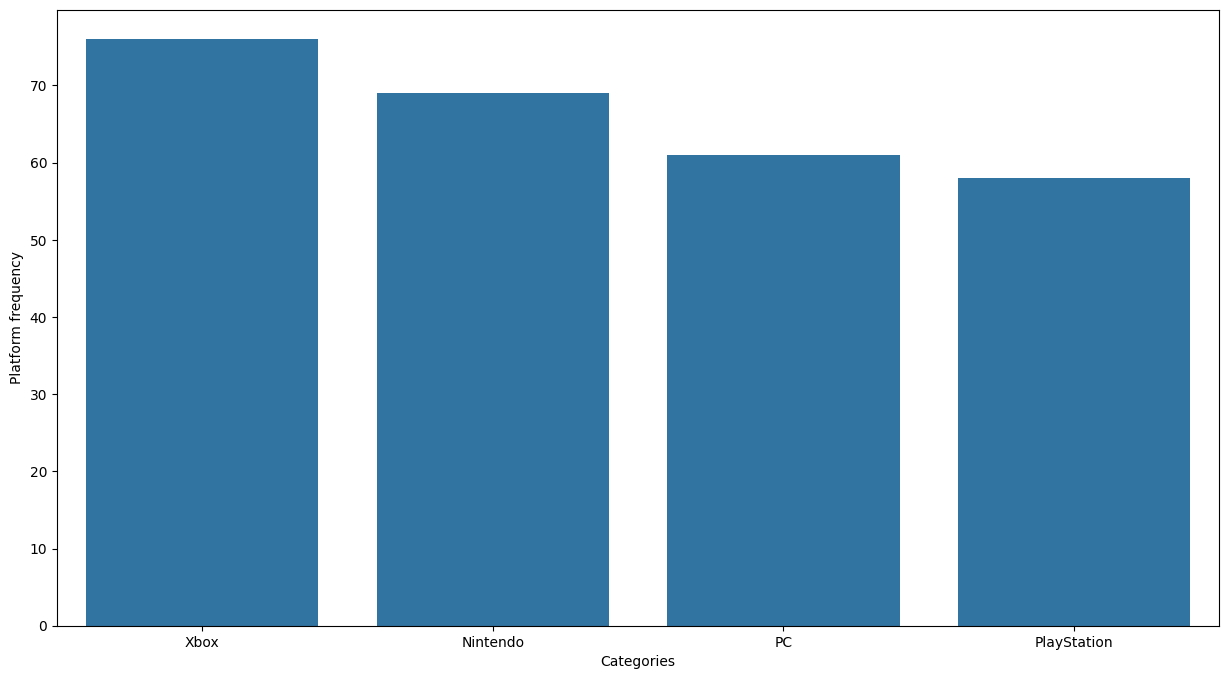

In [209]:
## platform count plot

platform_order = df["Platform"].value_counts().index.tolist()

plt.figure(figsize = (15, 8))

sns.countplot(data = df, x = "Platform", order= platform_order)

plt.xlabel("Categories")
plt.ylabel("Platform frequency")

plt.show(); plt.close()

<Axes: xlabel='Monthly_Sales'>

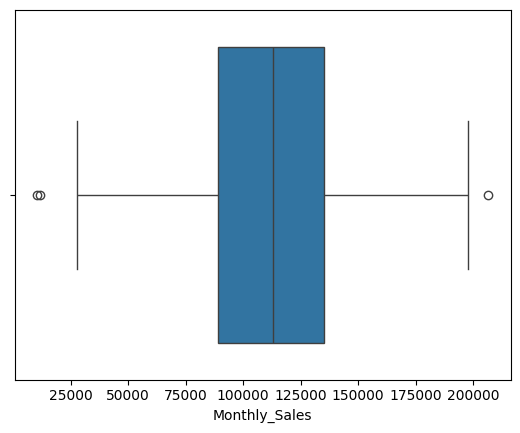

In [210]:
# check for outliers in Monthly Sales
sns.boxplot(x=df["Monthly_Sales"])

# 2.2 Bivariate analysis

In [211]:
# Get minimum and maximum year and month
min_date = df.index.min()
max_date = df.index.max()
print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2002-01-01 00:00:00
Maximum date: 2023-12-01 00:00:00


In [212]:
##discuss it

# Category by Year Sales
#plt.figure(figsize=(15,10))

#sns.countplot(data = df, x = 'Category', hue = 'Platform')

#plt.xlabel("Category By Platform Sales")
#plt.ylabel("Frequency")
#plt.show()

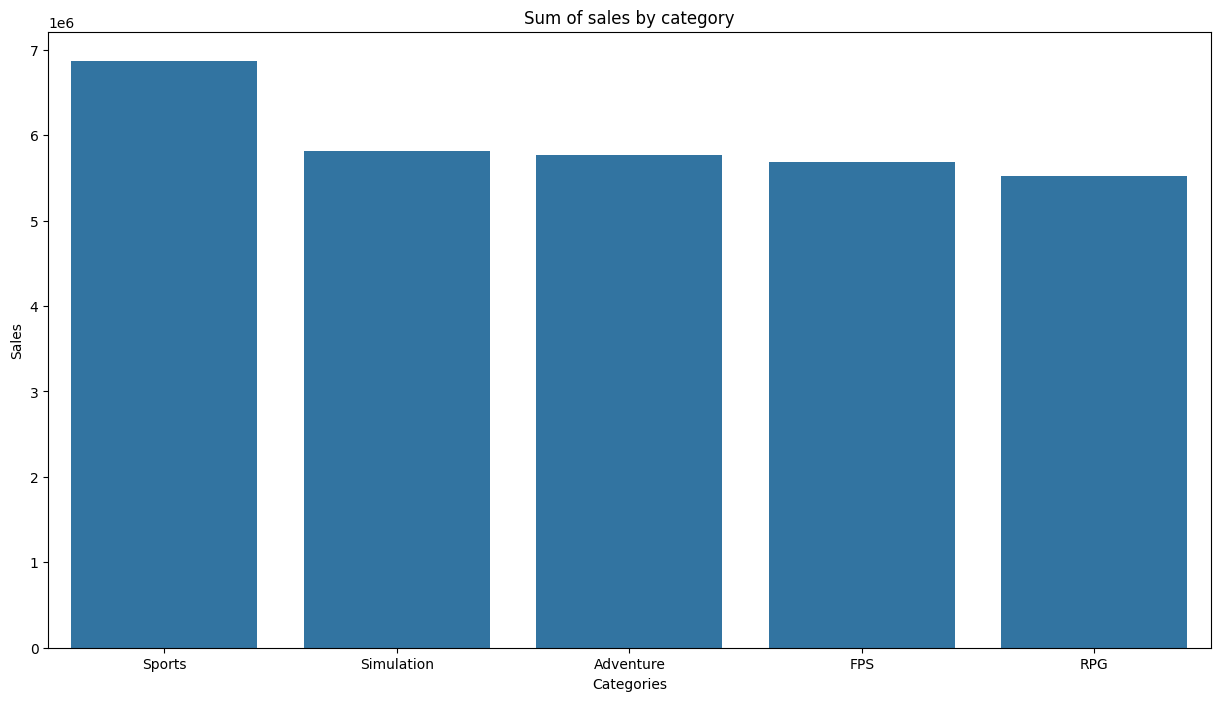

In [213]:
## Sales by category

category_order = df.groupby("Category")["Monthly_Sales"].sum().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Category", y= "Monthly_Sales", estimator = sum, order = category_order , errorbar=None)

plt.title("Sum of sales by category")
plt.xlabel("Categories")
plt.ylabel("Sales")

plt.show(); plt.close()

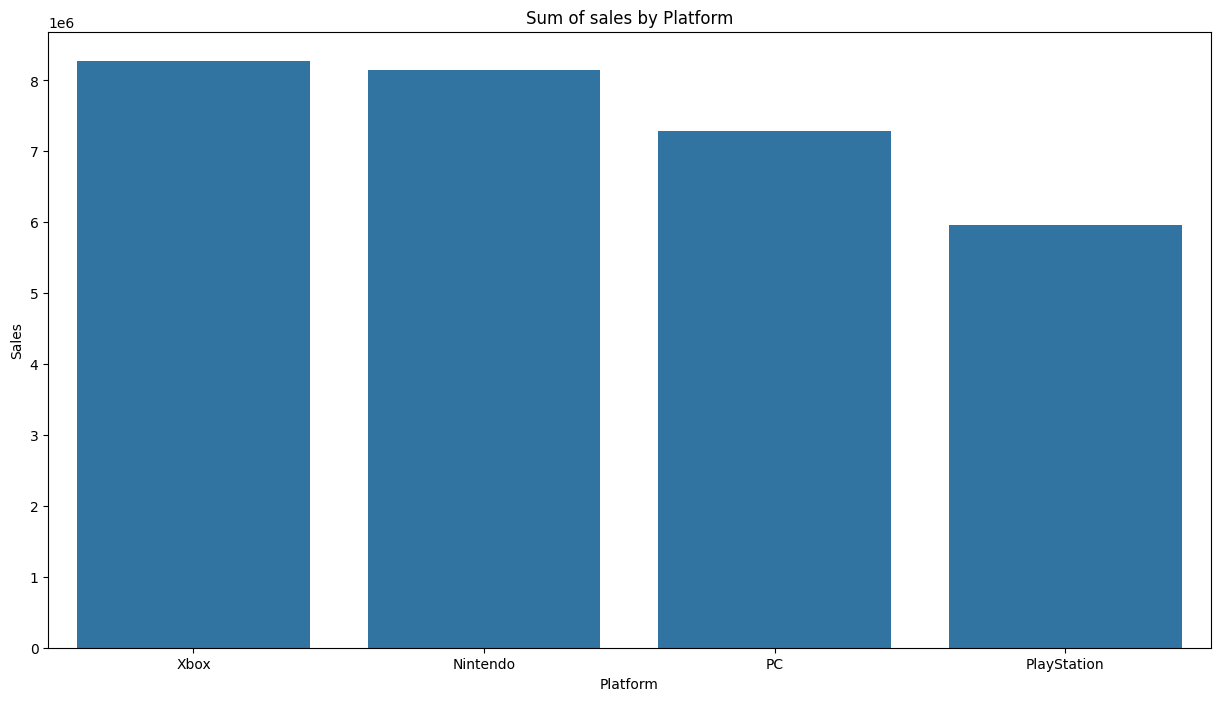

In [214]:
## Sales by platform

category_order = df.groupby("Platform")["Monthly_Sales"].sum().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Platform", y= "Monthly_Sales", estimator = sum, order = category_order , errorbar=None)

plt.title("Sum of sales by Platform")
plt.xlabel("Platform")
plt.ylabel("Sales")

plt.show(); plt.close()

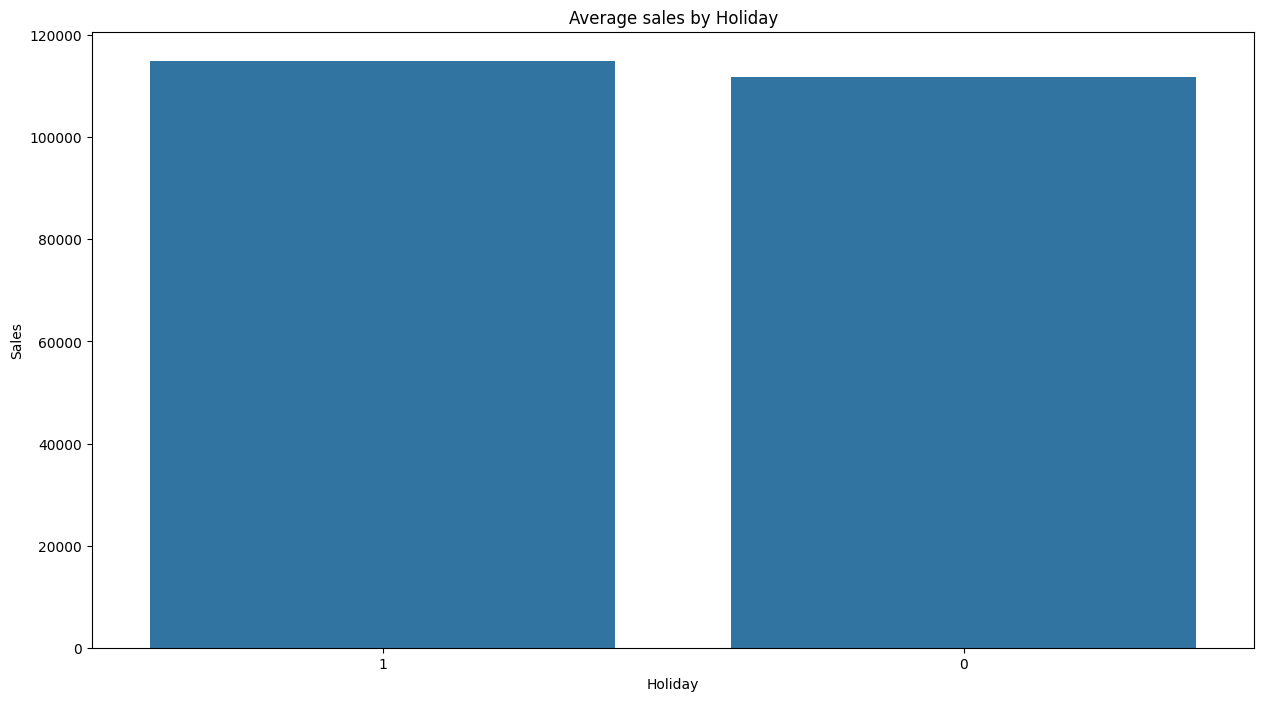

In [215]:
## Sales by Holiday

category_order = df.groupby("Holiday")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Holiday", y= "Monthly_Sales", order = category_order, errorbar=None )

plt.title("Average sales by Holiday")
plt.xlabel("Holiday")
plt.ylabel("Sales")

plt.show(); plt.close()

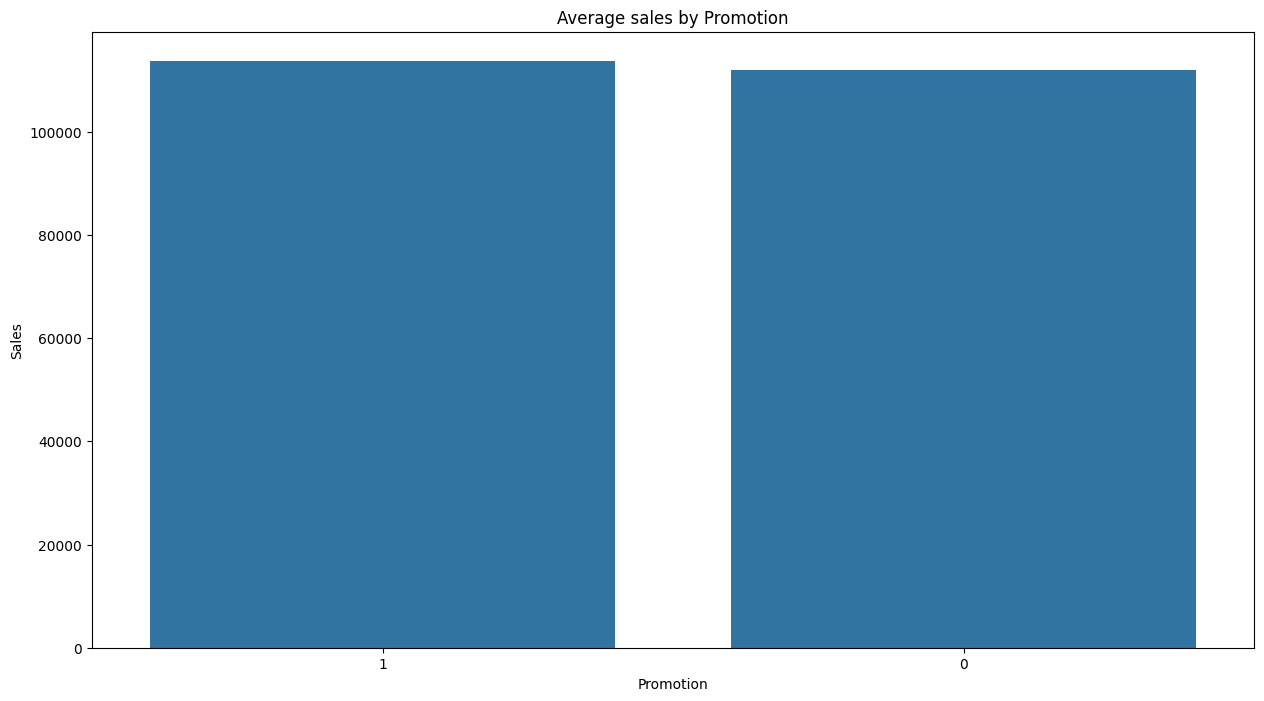

In [216]:
## Sales by Promotion

category_order = df.groupby("Promotion")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Promotion", y= "Monthly_Sales", order = category_order , errorbar=None)

plt.title("Average sales by Promotion")
plt.xlabel("Promotion")
plt.ylabel("Sales")

plt.show(); plt.close()

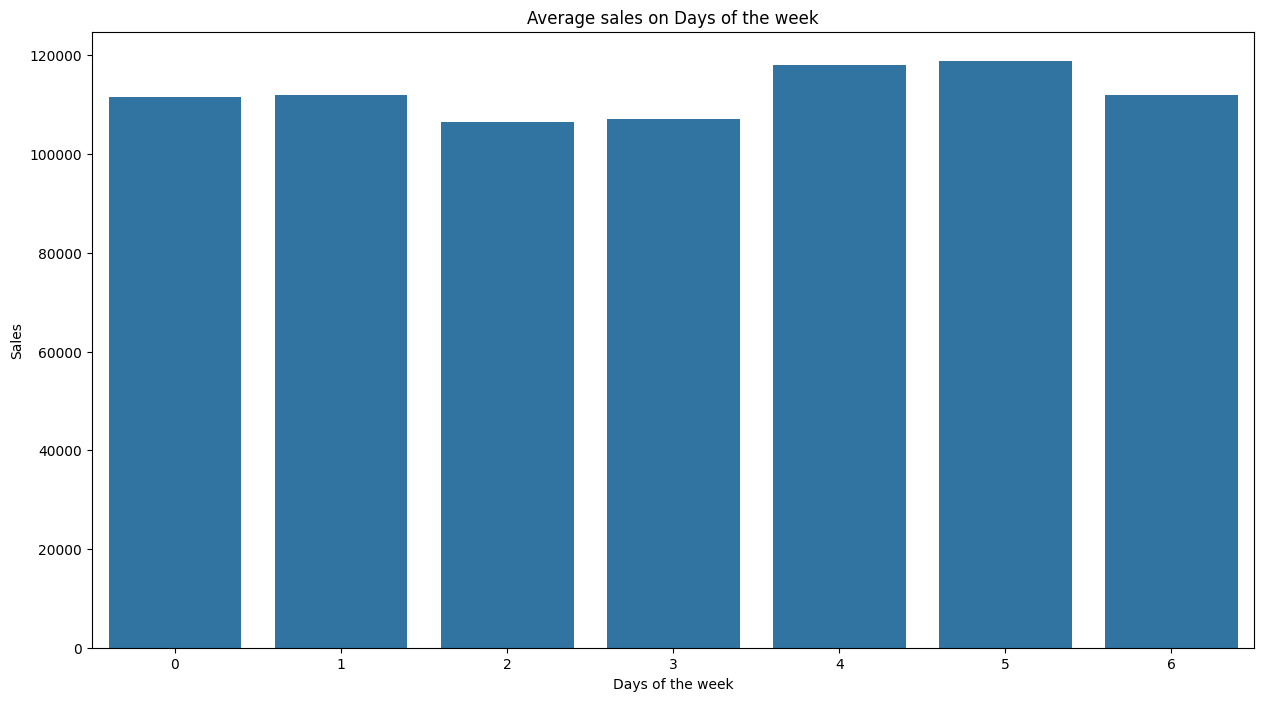

In [217]:
## Sales by Day of Week

#category_order = df.groupby("DayOfWeek")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "DayOfWeek", y= "Monthly_Sales", errorbar=None)

plt.title("Average sales on Days of the week")
plt.xlabel("Days of the week")
plt.ylabel("Sales")

plt.show(); plt.close()

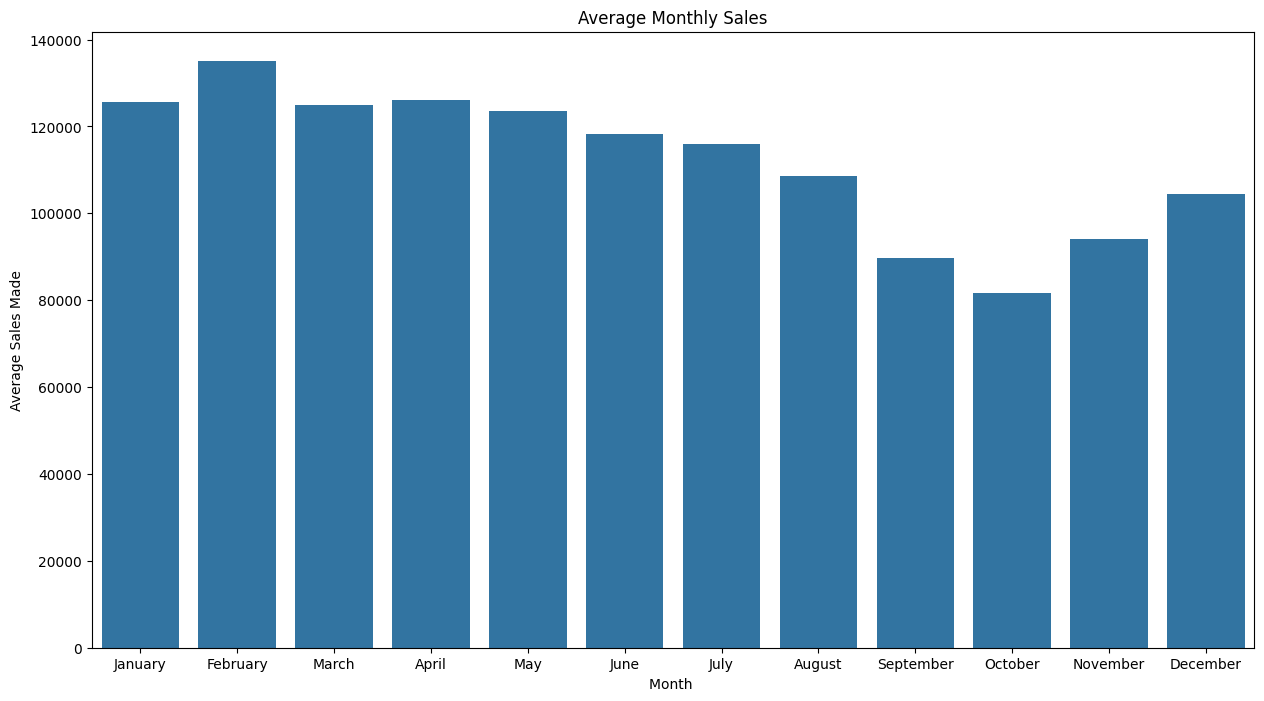

In [218]:
## visualize sales by month

# category_order = df.groupby("Month_Name")["Monthly_Sales"].mean().sort_values(ascending=False).index

plt.figure(figsize = (15, 8))

sns.barplot(data = df, x = "Month_Name", y = "Monthly_Sales", errorbar=None)

plt.title("Average Monthly Sales")
plt.xlabel("Month ")
plt.ylabel("Average Sales Made")

plt.show()

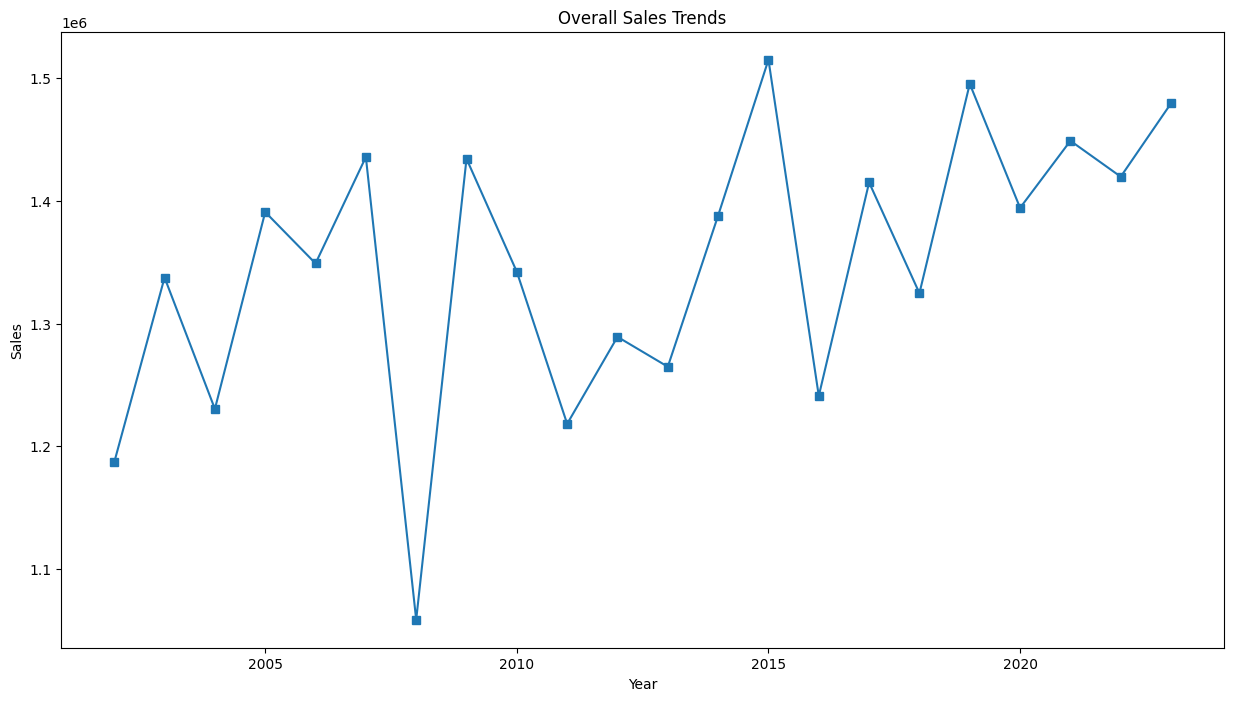

In [219]:

# Aggregate data for time series analysis
monthly_sales = df['Monthly_Sales']

# Overall sales trends
df.groupby('Year')['Monthly_Sales'].sum().plot(title="Overall Sales Trends", xlabel="Year", ylabel="Sales", marker = "s", figsize=(15, 8))
plt.show()

# 2.3 Multivariate Analysis

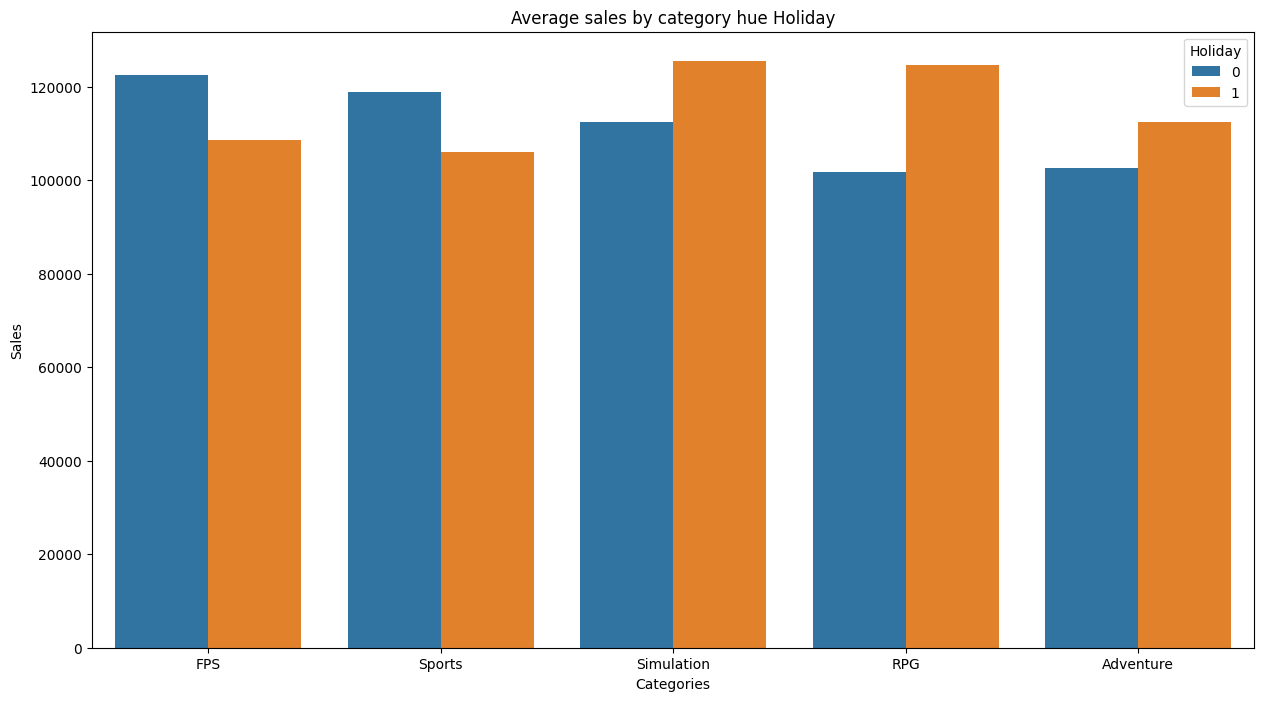

In [220]:
## Sales by category against Holiday

category_order = df.groupby("Category")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Category", y= "Monthly_Sales", hue= "Holiday", order = category_order , errorbar=None)

plt.title("Average sales by category hue Holiday")
plt.xlabel("Categories")
plt.ylabel("Sales")

plt.show(); plt.close()

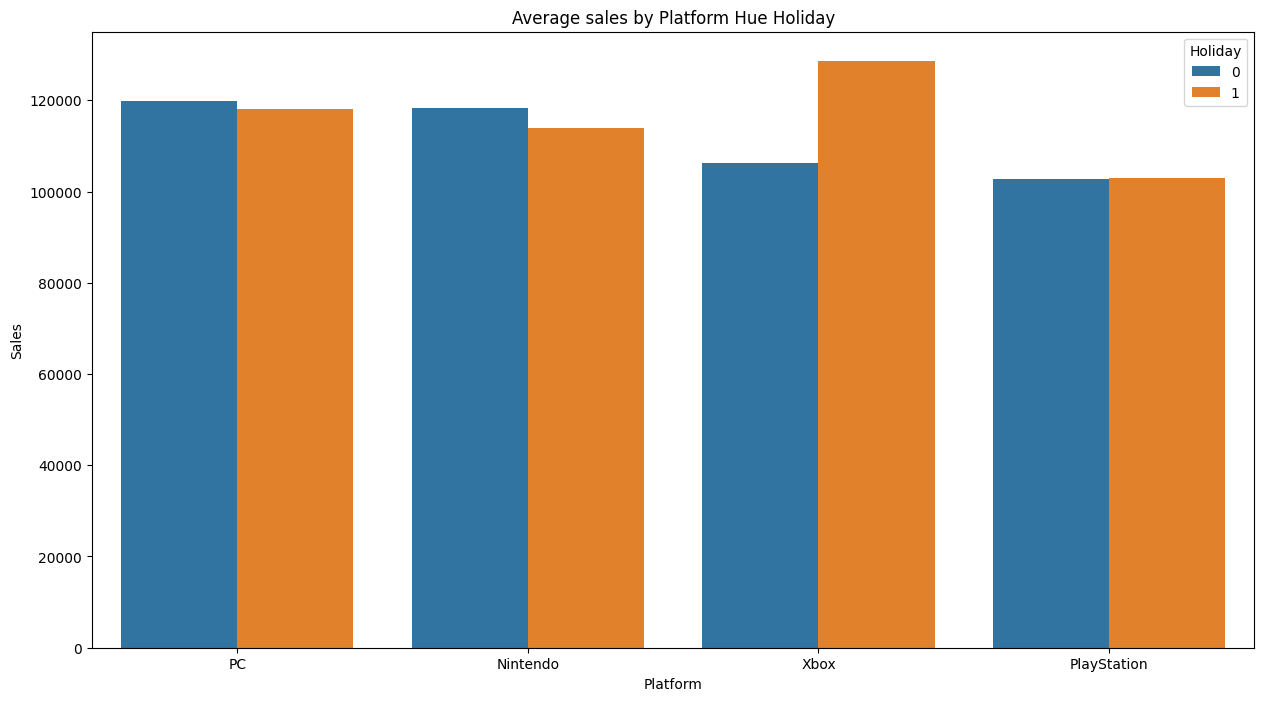

In [221]:
## Sales by platform against Holiday

category_order = df.groupby("Platform")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Platform", y= "Monthly_Sales", hue= "Holiday", order = category_order , errorbar=None)

plt.title("Average sales by Platform Hue Holiday")
plt.xlabel("Platform")
plt.ylabel("Sales")

plt.show(); plt.close()

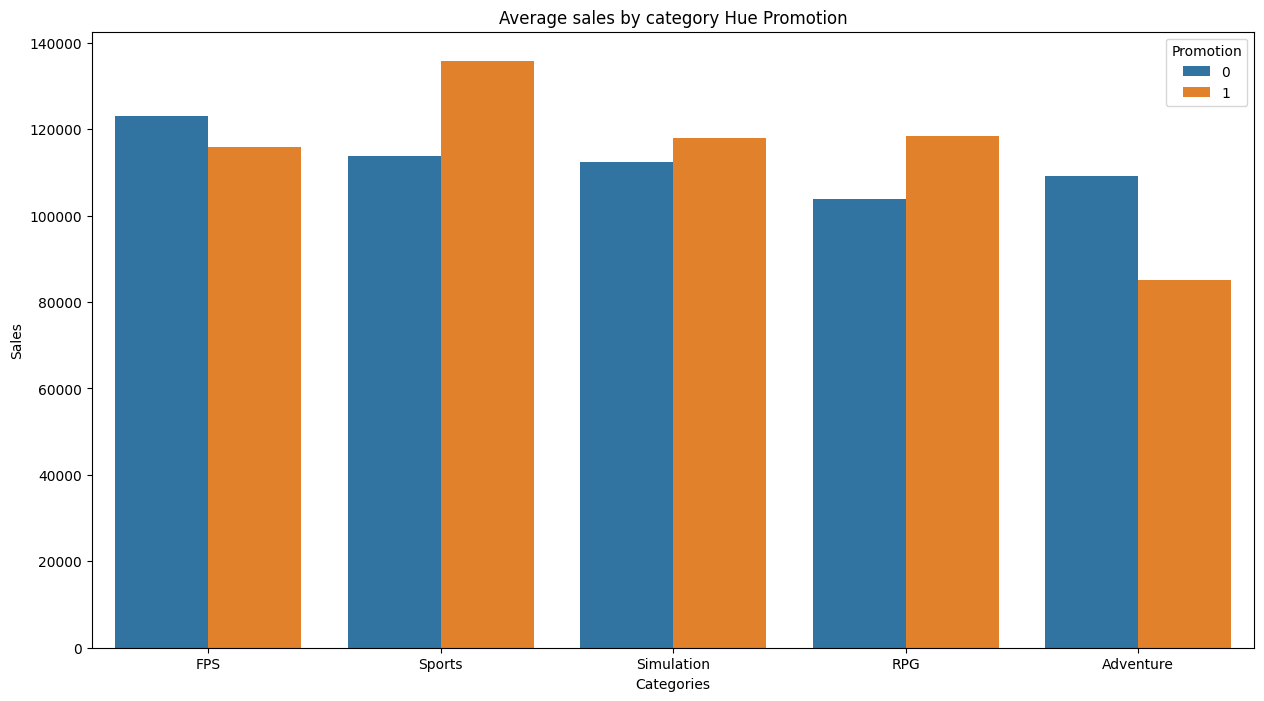

In [222]:
## Sales by category against Promotion

category_order = df.groupby("Category")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Category", y= "Monthly_Sales", hue= "Promotion", order = category_order , errorbar=None)

plt.title("Average sales by category Hue Promotion")
plt.xlabel("Categories")
plt.ylabel("Sales")

plt.show(); plt.close()

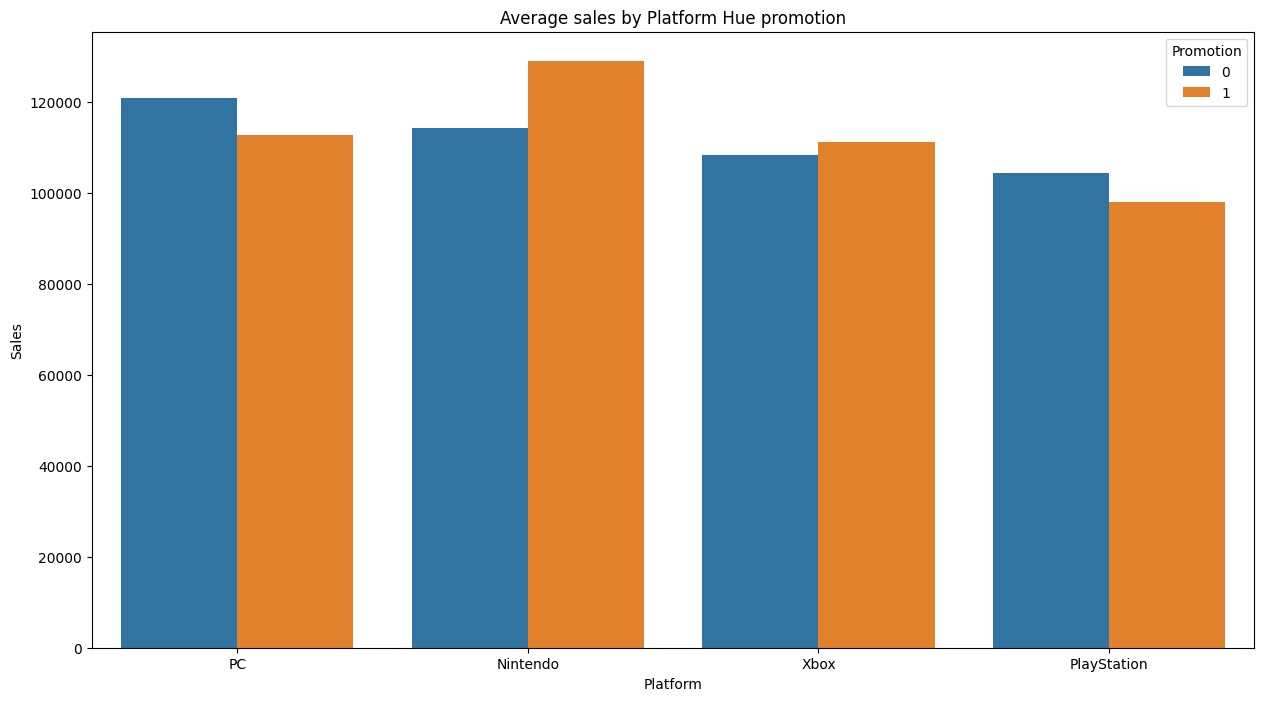

In [223]:
## Sales by platform against Promotion

category_order = df.groupby("Platform")["Monthly_Sales"].mean().sort_values(ascending=False).index


plt.figure(figsize = (15, 8))


sns.barplot(data = df, x = "Platform", y= "Monthly_Sales", hue= "Promotion", order = category_order , errorbar=None)

plt.title("Average sales by Platform Hue promotion")
plt.xlabel("Platform")
plt.ylabel("Sales")

plt.show(); plt.close()

Text(0, 0.5, 'Sales Made')

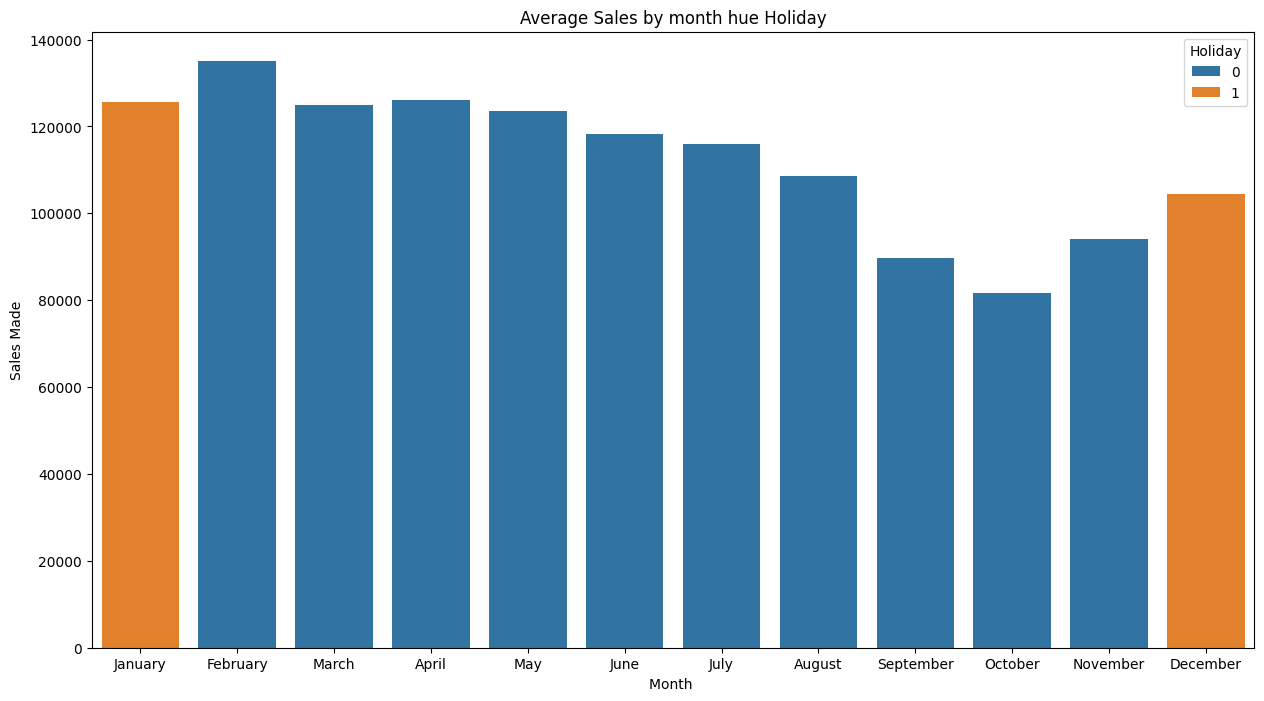

In [224]:
## Average sales by month hue Holiday

#category_order = df.groupby("Month_Name")["Monthly_Sales"].mean().sort_values(ascending=False).index

plt.figure(figsize = (15, 8))

sns.barplot(data = df, x = "Month_Name", y = "Monthly_Sales", hue= "Holiday", errorbar=None)

plt.title("Average Sales by month hue Holiday")
plt.xlabel("Month ")
plt.ylabel("Sales Made")

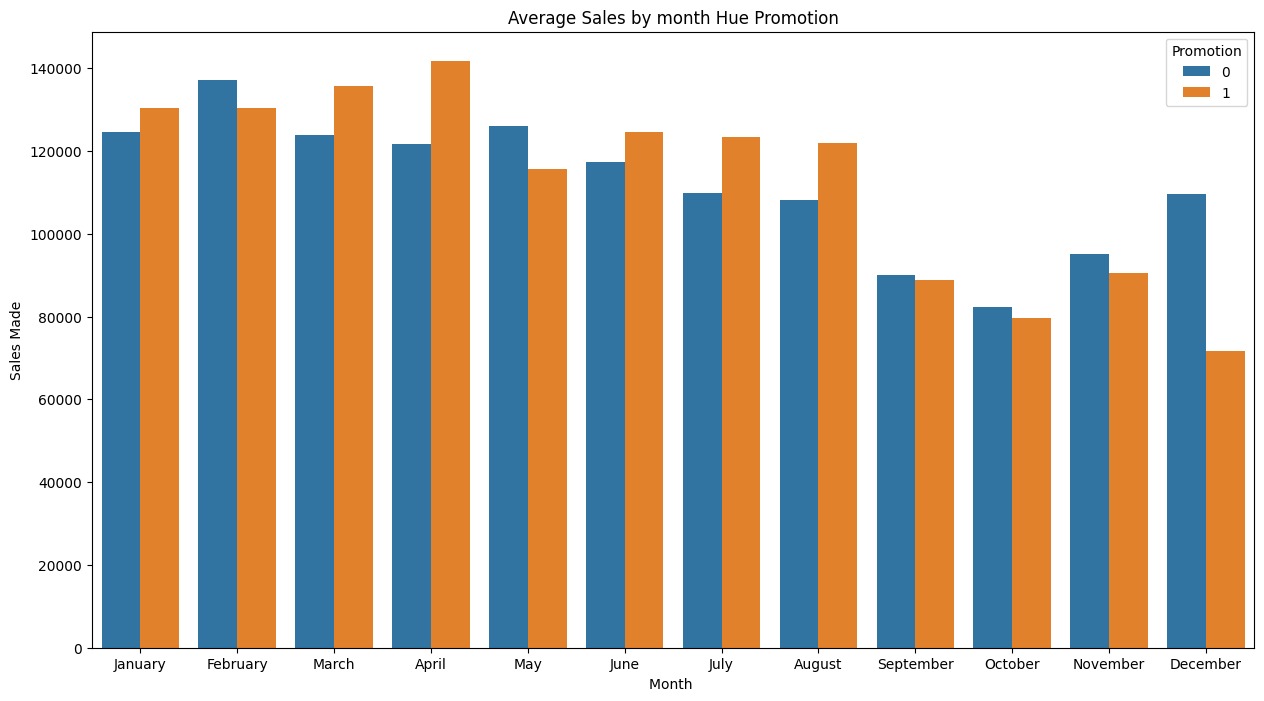

In [225]:
## Average sales by month hue Promotion

#category_order = df.groupby("Month_Name")["Monthly_Sales"].mean().sort_values(ascending=False).index

plt.figure(figsize = (15, 8))

sns.barplot(data = df, x = "Month_Name", y = "Monthly_Sales", hue= "Promotion", errorbar=None)

plt.title("Average Sales by month Hue Promotion")
plt.xlabel("Month ")
plt.ylabel("Sales Made")

plt.show()

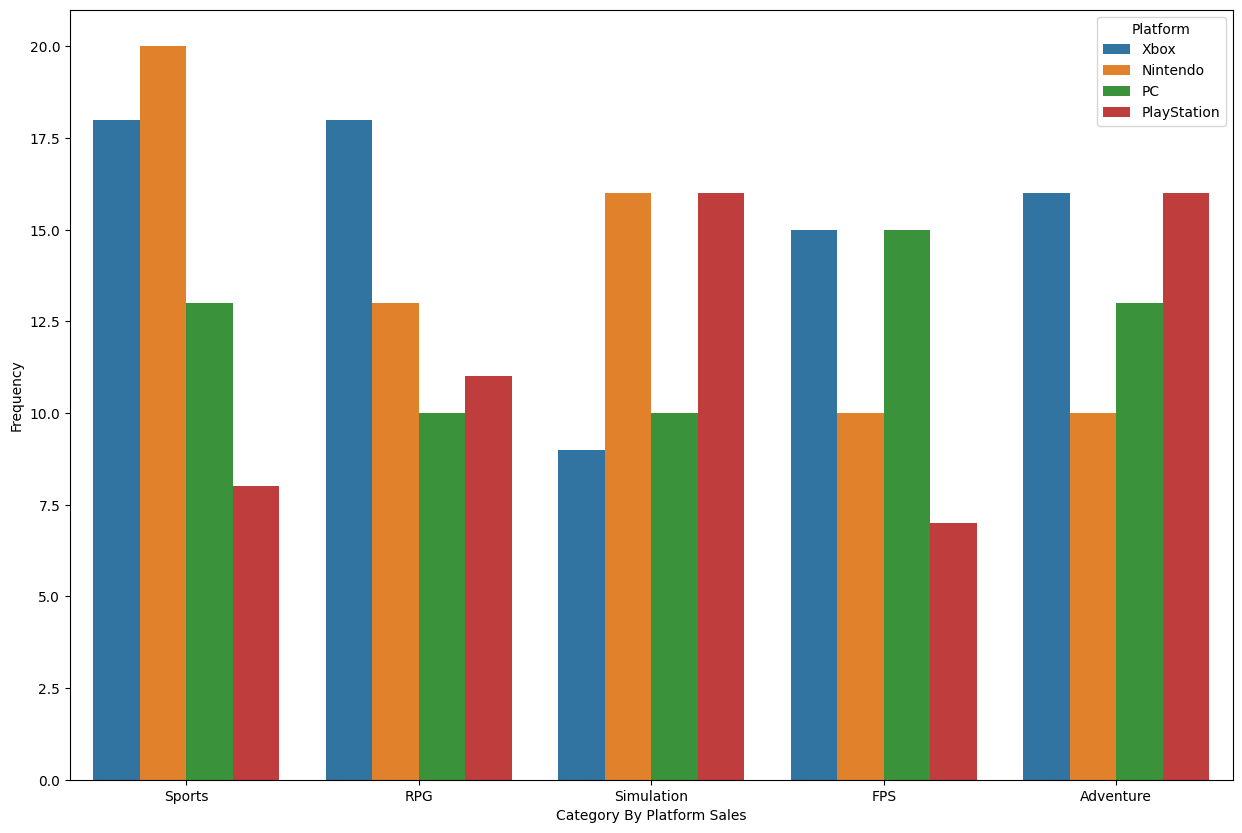

In [226]:
# Category by Year Sales
plt.figure(figsize=(15,10))

sns.countplot(data = df, x = 'Category', hue = 'Platform')

plt.xlabel("Category By Platform Sales")
plt.ylabel("Frequency")
plt.show()

# Comment:
1. Highest Sales by Category by Platform : Sports , Nintendo  is the higest platform sales in this category, followed by XBox platform
2. 2nd Highest Sales by Category by Platform : RPG , XBox  is the higest platform sales in this category, followed by Nintendo platform

In [227]:
# Impact of Holidays and Promotions
#holiday_sales = df[df['Holiday'] == 1]['Monthly_Sales'].mean()
#promotion_sales = df[df['Promotion'] == 1]['Monthly_Sales'].mean()
#print(f"Average sales during holidays: {holiday_sales}")
#print(f"Average sales during promotions: {promotion_sales}")

# 3.0 Data Stationality and Seasonality Check

# Check the Stationality and Seasonality of the Data

 Methods to perform this:
 1. Visual Inspection
 2. Global vs Local Check
 3. ADG(Augmented Dickney Fuller) Test -Statistical Tests
 4. KPPS Test - Statistical Tests
 
 # Time Series Models:

 1. Auto-Regression Model
 2. MA (Moving Average) Model
 3. ARMA( Auto Regression Moving Average) 
 4. ARIMA (Auto Regression  Integrated Moving Average) - almost  the same as ARMA, just does only one simple operation of convering non-stationary series to stationary series before
 5. ETS
 5. RNN
 5. LSTM

 # ACF  AND PACF Plots : measure the corellation between current time periods and previous time lags

**Correlation** is an indicator of relationship between 2 variables

**Auto-correlation**: Relationship of a variable with itd previous time period values(lags). Used Perason Corellation Co-efficient [-1.1]

**Auto-correlation Function**: Direct  and indirect effect of values in previous time lags on current value. Used to find order on MA Model

**Partial Auto-correlation Function**: Only direct effect of values in previous time lags on current value. Used to find order on Auto-Regression Model

In [228]:
# Modularized functions

def adf_test(series):
    """Performs the Augmented Dickey-Fuller test to check for stationarity."""
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The data is stationary based on the ADF test.")
    else:
        print("The data is not stationary based on the ADF test.")

def kpss_test(series):
    """Performs the KPSS test to check for stationarity."""
    kpss_stat, p_value, _, _ = kpss(series, regression='c')
    print('KPSS Statistic:', kpss_stat)
    print('p-value:', p_value)
    if p_value < 0.05:
        print("The data is not stationary based on the KPSS test.")
    else:
        print("The data is stationary based on the KPSS test.")

def plot_decomposition(series, period):
    """Plots seasonal decomposition of time series."""
    result = seasonal_decompose(series, model='additive', period=period)
    result.plot()
    plt.show()

def plot_acf_pacf(series, lags_acf=40, lags_pacf=40):
    """Plots the ACF and PACF of the series."""
    print("Plotting ACF and PACF...")
    plot_acf(series, lags=lags_acf)
    plt.show()
    plot_pacf(series, lags=lags_pacf)
    plt.show()

def compare_models(test, forecast_arima, forecast_ets, forecast_prophet):
    """Calculates RMSE and MAE for the models and ranks them."""
    # Calculate metrics
    rmse_arima = sqrt(mean_squared_error(test, forecast_arima))
    mae_arima = mean_absolute_error(test, forecast_arima)

    rmse_ets = sqrt(mean_squared_error(test, forecast_ets))
    mae_ets = mean_absolute_error(test, forecast_ets)

    forecast_prophet_test = forecast_prophet.iloc[-8:-4]['yhat']
    rmse_prophet = sqrt(mean_squared_error(test, forecast_prophet_test))
    mae_prophet = mean_absolute_error(test, forecast_prophet_test)

    # Create a DataFrame to compare models
    results = pd.DataFrame({
        "Model": ["ARIMA", "ETS", "FB Prophet"],
        "RMSE": [rmse_arima, rmse_ets, rmse_prophet],
        "MAE": [mae_arima, mae_ets, mae_prophet]
    })

    # Sort and display
    results_sorted = results.sort_values(by="RMSE", ascending=True)
    print("\nModel Performance Comparison:")
    print(results_sorted)

    return results_sorted.iloc[0]["Model"]


# 3.1 ADF Test

In [229]:
# ADF Test
print("ADF Test Result:")
adf_test(monthly_sales)

ADF Test Result:
ADF Statistic: -4.471046070251252
p-value: 0.00022173509005269144
The data is stationary based on the ADF test.


# 3.2 KPSS Test

In [230]:
# KPPS Test
print("KPPS Test Result:")
kpss_test(monthly_sales)

KPPS Test Result:
KPSS Statistic: 0.2905412089601993
p-value: 0.1
The data is stationary based on the KPSS test.


# 3.3 Seasonal decomposition

Seasonal Decomposition Plot:


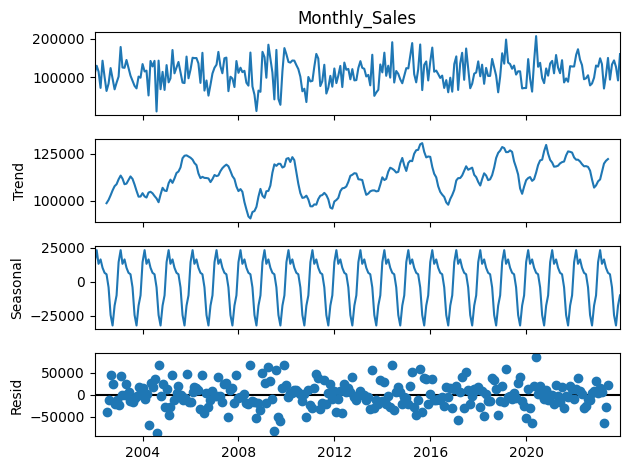

In [231]:
# Seasonal Decomposition
print("Seasonal Decomposition Plot:")
plot_decomposition(monthly_sales, period=12)

# 3.4 ACF and PACF plots

ACF and PACF plots:
Plotting ACF and PACF...


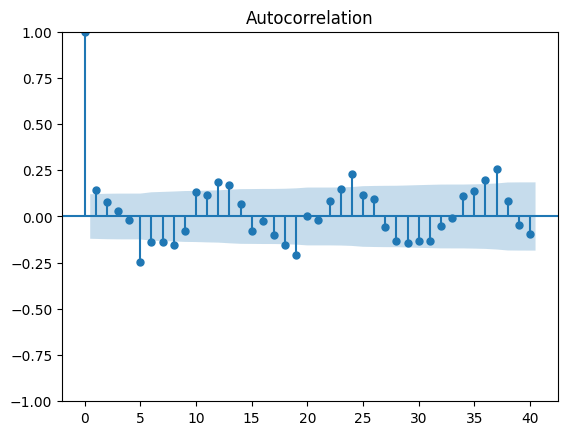

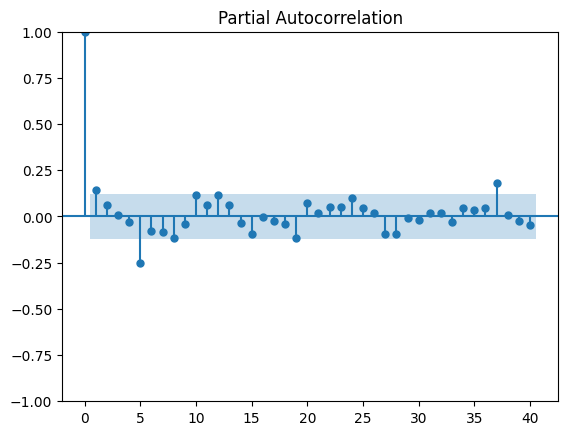

In [232]:
# ACF and PACF plots
print("ACF and PACF plots:")
plot_acf_pacf(monthly_sales)

# 3.4 Seasonal Plots

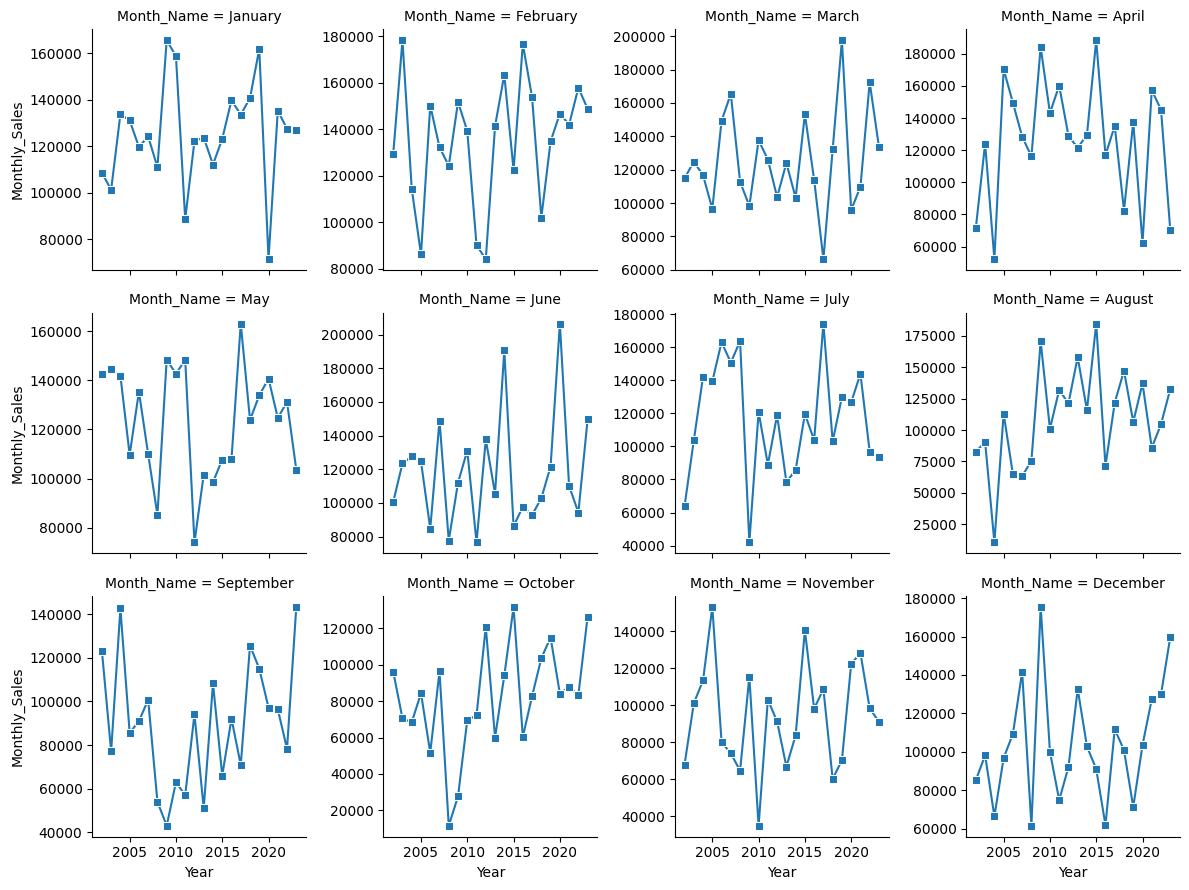

In [233]:
# Seasonal Plot
seasonal_df = df.copy()
seasonal_df['Year'] = seasonal_df.index.year
seasonal_df['Month_Name'] = seasonal_df.index.month_name()
g = sns.FacetGrid(seasonal_df, col='Month_Name', col_wrap=4, sharey=False)
g.map(sns.lineplot, 'Year', 'Monthly_Sales', marker="s")
plt.show()


 # 4.0 Model Building

In [234]:
# Splitting data into train and test sets
train = monthly_sales[:-4]
test = monthly_sales[-4:]

# 4.1 ARIMA Model

In [235]:
# ARIMA Model Buidling
print("Building ARIMA Model...")
model_arima = ARIMA(train, order=(2, 1, 2))
results_arima = model_arima.fit()
print(results_arima.summary())


Building ARIMA Model...
                               SARIMAX Results                                
Dep. Variable:          Monthly_Sales   No. Observations:                  260
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3073.473
Date:                Thu, 02 Jan 2025   AIC                           6156.945
Time:                        22:04:31   BIC                           6174.729
Sample:                    01-01-2002   HQIC                          6164.096
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7722      0.113     -6.850      0.000      -0.993      -0.551
ar.L2          0.1844      0.077      2.386      0.017       0.033       0.336
ma.L1         -0.0577      0

Forecast for January-April 2024:
ARIMA:
2024-01-01    116317.281337
2024-02-01    116682.887806
2024-03-01    113380.772513
2024-04-01    115998.181700
Freq: MS, Name: predicted_mean, dtype: float64
ARIMA Plot diagnostics...


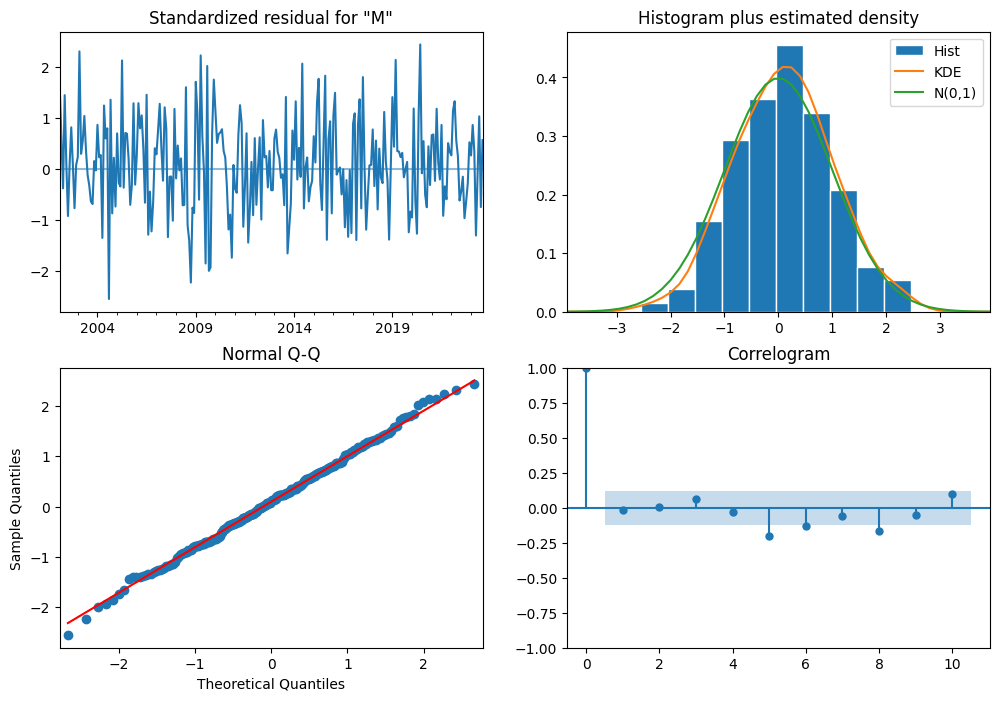

In [236]:
# Forecast with ARIMA
forecast_arima = results_arima.forecast(steps=4)

# Create a date range for the next 4 months
future_dates = pd.date_range(start="2024-01-01", periods=4, freq="MS")
forecast_arima.index = future_dates

print("Forecast for January-April 2024:")
print(f"ARIMA:\n{forecast_arima}")


# ARIMA Plot diagnostics
print("ARIMA Plot diagnostics...")
results_arima.plot_diagnostics(figsize=(12, 8))
plt.show()

# 4.2 # ETS (Exponential Smoothing) Model

In [237]:
print("Building ETS Model...")
model_ets = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
forecast_ets = model_ets.forecast(steps=4)

# Create a date range for the next 4 months
future_dates = pd.date_range(start="2024-01-01", periods=4, freq="MS")
forecast_ets.index = future_dates

print("Forecast for January-April 2024:")
print(f"ETS:\n{forecast_ets}")

Building ETS Model...
Forecast for January-April 2024:
ETS:
2024-01-01     93785.139523
2024-02-01     87079.858213
2024-03-01    100917.542380
2024-04-01    104431.955264
Freq: MS, dtype: float64


# 4.3 FB Prophet

In [238]:
# FB Prophet
print("Building FB Prophet Model...")
prophet_data = df.reset_index()[['Date', 'Monthly_Sales']]
prophet_data.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(prophet_data)
# Future dataframe for Prophet
future_dates = model_prophet.make_future_dataframe(periods=4, freq="MS")
forecast_prophet = model_prophet.predict(future_dates)

# Extract predictions for Jan-Apr 2024
forecast_prophet_test = forecast_prophet[forecast_prophet['ds'] >= "2024-01-01"].iloc[:4]

print("Forecast for January-April 2024:")
print(f"FB Prophet:\n{forecast_prophet_test[['ds', 'yhat']]}")

22:04:31 - cmdstanpy - INFO - Chain [1] start processing


Building FB Prophet Model...


22:04:31 - cmdstanpy - INFO - Chain [1] done processing


Forecast for January-April 2024:
FB Prophet:
            ds           yhat
264 2024-01-01  117224.845159
265 2024-02-01  129511.168242
266 2024-03-01  110022.335760
267 2024-04-01  125907.085237


# 5.0 Evaluate Models

In [239]:
# Evaluate Models
print("Evaluating Models...")
best_model = compare_models(test, forecast_arima, forecast_ets, forecast_prophet)
print(f"\nThe best model based on RMSE is: {best_model}")

Evaluating Models...

Model Performance Comparison:
        Model          RMSE           MAE
0       ARIMA  28417.864687  25671.605417
2  FB Prophet  33386.685800  28144.942365
1         ETS  42299.896742  38481.147345

The best model based on RMSE is: ARIMA



Final Forecast Comparison:
         Date       Model       Forecast
0  2024-01-01       ARIMA  116317.281337
1  2024-02-01       ARIMA  116682.887806
2  2024-03-01       ARIMA  113380.772513
3  2024-04-01       ARIMA  115998.181700
4  2024-01-01         ETS   93785.139523
5  2024-02-01         ETS   87079.858213
6  2024-03-01         ETS  100917.542380
7  2024-04-01         ETS  104431.955264
8  2024-01-01  FB Prophet  117224.845159
9  2024-02-01  FB Prophet  129511.168242
10 2024-03-01  FB Prophet  110022.335760
11 2024-04-01  FB Prophet  125907.085237

The best model based on RMSE is: ARIMA


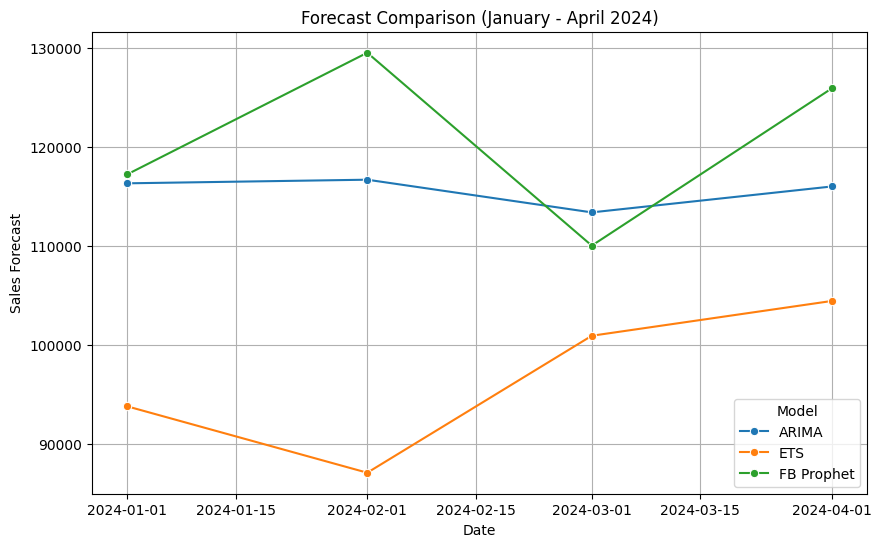

In [240]:
# Create a pandas DataFrame for the final forecasts
final_forecast_df = pd.DataFrame({
    "Date": pd.date_range(start="2024-01-01", periods=4, freq="MS"),
    "ARIMA": forecast_arima.values,
    "ETS": forecast_ets.values,
    "FB Prophet": forecast_prophet_test['yhat'].values
})

# Melt the DataFrame for easier comparison and plotting
melted_forecast_df = final_forecast_df.melt(id_vars=["Date"], var_name="Model", value_name="Forecast")

# Sort the DataFrame based on the ARIMA model (best RMSE)
sorted_forecast_df = melted_forecast_df[melted_forecast_df['Model'] == "ARIMA"]
sorted_forecast_df = pd.concat([sorted_forecast_df, melted_forecast_df[melted_forecast_df['Model'] != "ARIMA"]])

# Display the sorted forecast
print("\nFinal Forecast Comparison:")
print(sorted_forecast_df)

# Comment on the best results
print(f"\nThe best model based on RMSE is: ARIMA")

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the forecasts
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_forecast_df, x="Date", y="Forecast", hue="Model", marker="o")
plt.title("Forecast Comparison (January - April 2024)")
plt.xlabel("Date")
plt.ylabel("Sales Forecast")
plt.legend(title="Model")
plt.grid()
plt.show()


# 6.0 Final Forecast

Final Forecast:
Forecast for the next 4 months:
2024-01-01    116317.281337
2024-02-01    116682.887806
2024-03-01    113380.772513
2024-04-01    115998.181700
Freq: MS, Name: predicted_mean, dtype: float64


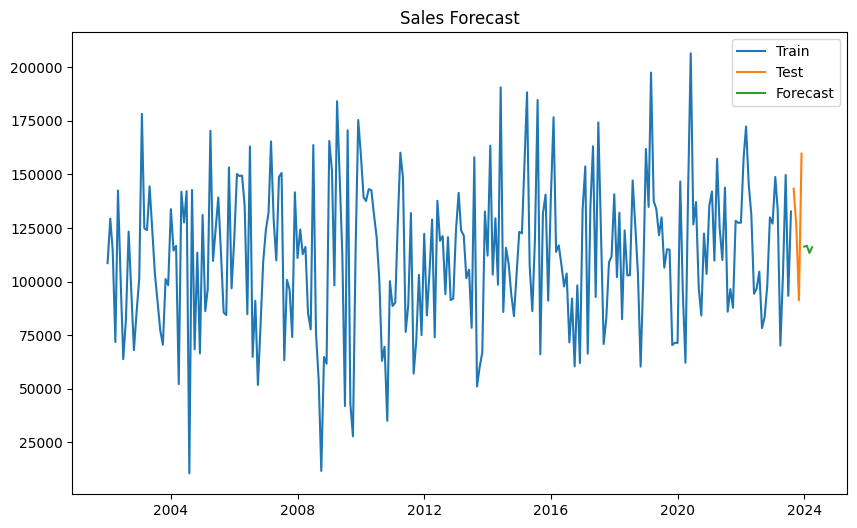

In [241]:
# Final Forecast
print("Final Forecast:")
final_forecast = forecast_arima if best_model == "ARIMA" else (
    forecast_ets if best_model == "ETS" else forecast_prophet.iloc[-4:]['yhat']
)
# Step 5: Final Forecast
print("Forecast for the next 4 months:")
print(final_forecast)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(final_forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Sales Forecast')
plt.show()
